# Preprocessing data for Qptuna

## Introduction <a class="anchor" id="intro"></a>

Probably the most important step in using the automated parameter optimization is the preprocessing of the data prior to training the model. Common considerations include how to deal with duplicates SMILES having different read-out values, if and how to split the data into a training and (holdout) test set, and how to prepare input files in a proper way (e.g. transform SDF files into a dataframe with SMILE string- and read-out-columns).

The Qptuna (`Optuna_AZ`) packages have some built-in functionality to facilitate that process.

Start with imports.

In [1]:
import pandas as pd
import numpy as np
import random

from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display, HTML

from os import listdir
from os.path import isfile, join
from os import walk

#load code from the "Optuna_AZ" package that comes in handy here
%run ../optunaz/utils/preprocessing/deduplicator.py
%run ../optunaz/utils/preprocessing/splitter.py

/var/folders/1v/9y_z128d7gvcp8mf8q0pz3ch0000gq/T/ipykernel_82497/796203442.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# load the plotting libraries, in case needed
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting parameters
large = 20; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

/var/folders/1v/9y_z128d7gvcp8mf8q0pz3ch0000gq/T/ipykernel_82497/3336016810.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Translate from SDF to CSV (if needed)  <a class="anchor" id="csv"></a>

Qptuna can use either SMILES strings (no stereochemistry!) or SDF as input molecular representation.

SMILES input is a comma-separated values (CSV) file with a SMILES column and a read-out (response) column. Read-out (response) column can be either numeric values (for regression) or labels (for classification). Note, that labels can be in the form of integer/boolean values - as long as the optimization process is specified as `classification`, they will be translated into nominal data values. SDF files should have the response column provided within the SDF file.

Data provided in SDF format can (optionally - since Qptuna can accept SDF files) be converted to a SMILES file (so that any optional more advanced preprocessing can be conducted) using the following code.

In [3]:
file = "../tests/data/sdf/example.sdf"
primarydf = PandasTools.LoadSDF(file)

In [4]:
primarydf.head()

,Molecule Name,Measurement,Measurement Unit,Smiles,pXC50,InChI,InChI-Key,Similarity SkeletonSpheres,Activity [nM],Activity Type,Target,ID,ROMol
0,Compound 2,990.1,IC50 (µM),c1ccc2c(c1)NC(=O)CO2,3.004320939,InChI=1S/C8H7NO2/c10-8-5-11-7-4-2-1-3-6(7)9-8/...,QRCGFTXRXYMJOS-UHFFFAOYSA-N,0.86075,0.74,IC50,MAP kinase p38 alpha,Compound 1,<rdkit.Chem.rdchem.Mol object at 0x7fd1c0d34040>
1,Compound 4,13.11,IC50 (µM),c1ccc(cc1)CCc2ccccc2OCc3ccc(cc3)C(=O)O,4.882397308,InChI=1S/C22H20O3/c23-22(24)20-14-11-18(12-15-...,YTDAOQYEYFCINY-UHFFFAOYSA-N,0.89637,95,Kd,Retinoid X receptor alpha,Compound 2,<rdkit.Chem.rdchem.Mol object at 0x7fd1f8f965e0>
2,Compound 5,7.408,IC50 (µM),c1ccc(cc1)CCc2ccccc2OCc3ccc(cc3)C(=O)O,5.130299026,InChI=1S/C22H20O3/c23-22(24)20-14-11-18(12-15-...,YTDAOQYEYFCINY-UHFFFAOYSA-N,0.89637,95,Kd,Retinoid X receptor alpha,Compound 3,<rdkit.Chem.rdchem.Mol object at 0x7fd1f8f96650>
3,Compound 7,330,IC50 (µM),c1ccc2c(c1)ccc(=O)[nH]2,3.48148606,InChI=1S/C9H7NO/c11-9-6-5-7-3-1-2-4-8(7)10-9/h...,LISFMEBWQUVKPJ-UHFFFAOYSA-N,1,93\n93\n82\n82\n65\n65\n36\n36\n33\n33\n82\n93...,Ki\nKi\nKi\nKi\nKi\nKi\nKi\nKi\nKi\nKi\nKi\nKi...,Carbonic anhydrase XII\nCarbonic anhydrase XII...,Compound 4,<rdkit.Chem.rdchem.Mol object at 0x7fd1f8f966c0>
4,Compound 8,990.1,IC50 (µM),CC(=O)Nc1ccccn1,3.004320939,InChI=1S/C7H8N2O/c1-6(10)9-7-4-2-3-5-8-7/h2-5H...,QROKOTBWFZITJZ-UHFFFAOYSA-N,0.86233,1,Ki,Nicotinate phosphoribosyltransferase,Compound 5,<rdkit.Chem.rdchem.Mol object at 0x7fd1f8f96730>


In [5]:
# get the important columns (activity values and calculated SMILES) and rename them for convenience
# drop the rest
primarydf["activity"] = primarydf["pXC50"].astype(float)
primarydf["smiles"] = [Chem.MolToSmiles(mol, isomericSmiles=False) for mol in primarydf["ROMol"]]
primarydf = primarydf[["smiles", "activity"]]
primarydf.head()

,smiles,activity
0,O=C1COc2ccccc2N1,3.004321
1,O=C(O)c1ccc(COc2ccccc2CCc2ccccc2)cc1,4.882397
2,O=C(O)c1ccc(COc2ccccc2CCc2ccccc2)cc1,5.130299
3,O=c1ccc2ccccc2[nH]1,3.481486
4,CC(=O)Nc1ccccn1,3.004321


Note, that there is no need to stick to this column-naming convention - both the preprocessing engine and `Optuna_AZ` allow you to specify the column names to be used explicitly.

## Deal with duplicates (Deduplication)  <a class="anchor" id="dedup"></a>

Let's assume you have a proper `pandas` dataframe at this stage, with one column for the molecules as SMILES and one read-out column (numeric activity values in this example). Depending on how you obtained your dataset and whether it is already processed, you might have the same molecule present more than once (duplicates), probably with (hopefully slightly) different values. As these pose a potential problem afterwards, it might be wise to use only unique observations, i.e. remove all instances of duplicated molecules but one. 

There are different strategies to remove duplicates, which will are outlined below.
* `KeepFirst()` and `KeepLast()`: keep the first or last occurrence of each duplicate.
* `KeepRandom(seed)`: keep a random observation for each duplicate. Note, that the order of observations is not preserved. Use the `seed` parameter to vary results or to reproduce them.
* `KeepMin()` and `KeepMax()`: keep min or max value.
* `KeepAvg()`: take the average for all duplicates.
* `KeepMedian()`: (default in Qptuna) take the median for all duplicates.

The default deduplication method in Qptuna is KeepMedian, which is recommended best practice due the ability to utilise all experimental data into one value (account for experimental variability across replicated), whilst being robust to outliers.

Each of the deduplication methods returns a unique version of the stored dataframe.

In [6]:
import sys
sys.path.append("..")

from optunaz.utils.preprocessing.deduplicator import *

col = "smiles"

df_pos = KeepFirst().dedup(primarydf, col)
df_rnd = KeepRandom().dedup(primarydf, col)
df_max = KeepMax().dedup(primarydf, col)
df_avg = KeepAvg().dedup(primarydf, col)
df_med = KeepMedian().dedup(primarydf, col)

# print sizes
print(f"original: {len(primarydf)}, deduplidcated: {len(df_pos)}, {len(df_rnd)}, {len(df_max)}, {len(df_avg)}, {len(df_med)}")

original: 397, deduplidcated: 38, 38, 38, 38, 38


To print duplicate, use Pandas DataFrame method `duplicated()` to get indicies of the duplicates.

In [7]:
idx = primarydf.duplicated(subset='smiles')
print(primarydf[idx])

                                                smiles  activity
2                 O=C(O)c1ccc(COc2ccccc2CCc2ccccc2)cc1  5.130299
6        COc1cc2ncnc(Nc3ccc(SCc4ccccc4)c(Cl)c3)c2cc1OC  5.282579
7                                  O=c1ccc2ccccc2[nH]1  3.004321
8                                     O=C1COc2ccccc2N1  4.912929
10               Cc1cccc(Nc2ncnc3ccc(-c4ccccc4)cc23)c1  5.004321
..                                                 ...       ...
389  CC(=O)c1nn(CC(=O)N2CC(F)CC2C(=O)Nc2cccc(Br)n2)...  8.065502
390                                    CC(=O)Nc1ccccn1  3.958607
392                NC(=O)c1ccc(Oc2cccc(C(F)(F)F)c2)cc1  3.004321
394  Cn1nc(-c2cnc(Cl)c(-c3ccc(C(N)=O)cc3)n2)nc1C1(c...  4.958607
396  CCC(Oc1nc(Oc2cc(-c3ccccc3)cc(-c3cccc(CN)c3)c2)...  5.936291

[359 rows x 2 columns]


### Interlude: Compare the different unification strategies  <a class="anchor" id="interlud1"></a>
Depending on the way duplicates are removed, the resulting activity-value distribution is (slightly) different. Both `uniquify_by_position()` and `uniquify_randomly()` are in essence a random selection, while `uniquify_by_value()` will result in the distribution with the highest values (see mean values below).

Note, however, that only few (~40) duplicates were present in the data, so the effect is minimal for this dataset.

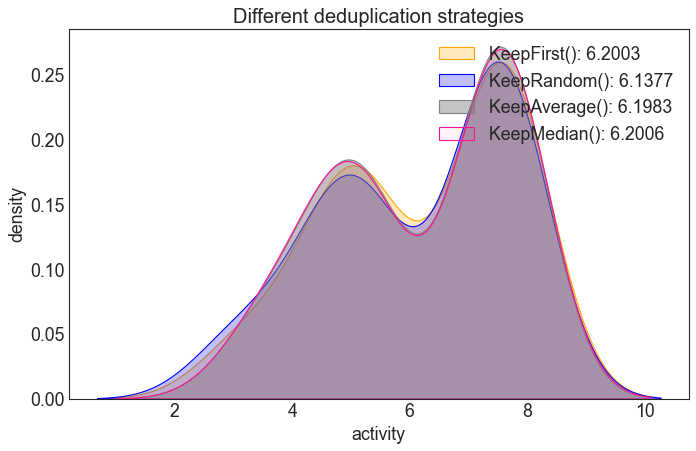

In [8]:
# make a density plot to compare the strategies
plt.figure(figsize=(10,6), dpi=80)

plt.xlabel("activity")
plt.ylabel("density")
plt.title("Different deduplication strategies", fontsize=18)
sns.kdeplot(df_pos["activity"], shade=True, color="orange", alpha=0.25,
            label = "KeepFirst(): %s" % round(df_pos["activity"].mean(), ndigits=4))
sns.kdeplot(df_rnd["activity"], shade=True, color="blue", alpha=0.25,
            label ="KeepRandom(): %s" % round(df_rnd["activity"].mean(), ndigits=4))
sns.kdeplot(df_avg["activity"], shade=True, color="grey", alpha=0.45,
            label = "KeepAverage(): %s" % round(df_avg["activity"].mean(), ndigits=4))
sns.kdeplot(df_med["activity"], shade=True, color="deeppink", alpha=0.05,
            label = "KeepMedian(): %s" % round(df_med["activity"].mean(), ndigits=4))
# do the legend and render
plt.legend(loc="upper right")
plt.show()

## Splitting the data  <a class="anchor" id="split"></a>

While it is recommended to use a hold-out / test set to independently assess your model's performance after the fitting procedure, this step might be skipped, e.g. if your dataset is small and you want to use all observations for training the model. However, usually it would be advisable to separate a hold-out set now (typically about 20% of observations). There are different strategies, depending on your data and aims.

### Random split  <a class="anchor" id="rand"></a>

It is typically not a good idea to simply take, say, the first 20% of observations and train on the rest. It could very well be, that your data points have some kind of internal ordering such as a temporal dependence. In general, you would want to have your test set to resemble the same (or similar) distribution than the training set.

The easiest way to achieve that is to simply draw observations randomly. This works especially well if you have large datasets, where you can rely on a stochastic behaviour. See example below. Note, that you can use the `seed` parameter to control the initial seed of the random number generator.

In [9]:
# generate a training and test, respectively
train_ran, test_ran = Random(fraction=0.3, seed=42).split(df_med["smiles"])

print("Train (random):", len(train_ran))
print("Test (random):", len(test_ran))

Train (random): 26
Test (random): 12


### Temporal split  <a class="anchor" id="temp"></a>
Sometimes it might be interesting to split the data according to a `time_column`, to e.g. group all old datapoints into the training set and all data points accrued after a specified time into the test set.

Temporal splitting achieves this, and assumes that the data is sorted, with the oldest entries in the beginning of the file, and the newest entries added at the end.

As our test input does not have a specific `time_column` to indicate sorting, we will assume that the observations were made with a timestamp recorded, but new observations were added at the top.

In [10]:
# make a copy of the dataframe for illustrative purposes
df_med_temporal = df_med.copy()

# add a "fake" time_column with timestamps
df_med_temporal.insert(2, "timestamp",
                       list(reversed(range(1000, 1000 + len(df_med_temporal)))))
df_med_temporal.head()

,smiles,activity,timestamp
0,CC(=O)NCCCCCCOc1ccc2c(c1)c(NC(=O)N1CC(F)CC1C(=...,7.684240,1037
1,CC(=O)Nc1ccccn1,3.481464,1036
2,CC(=O)c1cn(CC(=O)N2C(C(=O)Nc3cccc(Br)n3)CC3CC3...,7.732625,1035
3,CC(=O)c1cn(CC(=O)N2CC(F)CC2C(=O)Nc2cccc(Br)n2)...,7.568332,1034
4,CC(=O)c1nn(CC(=O)N2C(C(=O)Nc3cccc(Br)n3)CC3CC3...,7.790259,1033


In [11]:
# initialize a new splitter with this extended data
train_temporal, test_temporal = Temporal(fraction=0.1).split(df_med_temporal)

print("Train (temporal):", len(train_temporal))
print("Test (temporal):", len(test_temporal))

Train (temporal): 34
Test (temporal): 4


### Stratified split  <a class="anchor" id="strat"></a>
Sometimes (especially for small datasets, using only a very small fraction for testing or highly skewed distributions) it might be better to use a *stratified* splitting strategy. Essentially, it will bin the observations according to the value column `respCol` and instead of drawing `fraction` observations from the whole dataset, draw them individually from each bin. This ensures that the distributions of the training and test sets are very close. See example below. Note, that while it is possible to specify a number of bins using parameter `bins`, it is probably better to use the default "fd" (see `numpy.histogram` documentation) which will try to determine a well-balanced number of bins automatically taking the data variability and variance into account.

In [12]:
# generate a training and test, respectively

train_str, test_str = Stratified(fraction=0.4, seed=42).split(df_med["smiles"], df_med["activity"])

print("Train (stratified):", len(train_str))
print("Test (stratified):", len(test_str))

Train (stratified): 22
Test (stratified): 16


### Scaffold-based split  <a class="anchor" id="strat"></a>
A scaffold based split affords the generation of a more real-world/realistic split when a model is trained on a given set of chemical scaffolds (core ring system) and deplopyed to a new set of scaffolds. This emulates a real-world situation when QSAR models used to identify scaffold-hopping opportunities or to new chemical series distinct to training data. These situations push the applicability domain of the models (the area of chemical space that they are realible) to the limit. A scaffold-split is hence the most challenging of the splitting strategies employed.

In [13]:
# generate a training and test, respectively
scaf_split = ScaffoldSplit()
scaffolds = scaf_split.groups(df_med, "smiles")
groups = df_med["smiles"].map(scaffolds)
train_sca, test_sca = scaf_split.split(df_med["smiles"], df_med["activity"], groups=groups)

print("Train (stratified):", len(train_sca))
print("Test (stratified):", len(test_sca))

Train (stratified): 34
Test (stratified): 4


### Interlude: Compare splitting strategies  <a class="anchor" id="interlud2"></a>
The following code will plot the ground distribution for the activity (stored in `df_val`) and the train-test distributions obtained from one of the splitting strategies. This is a good example why caution is in order when using temporal splitting: if the data distributions are different between training and test sets, the resulting model will likely not generalize well to the test set. The random split roughly resembles the ground distribution, but it is evident, that the stratified does an even better job in this respect. For (very) large datasets, the difference between the latter two will likely be less pronounced.

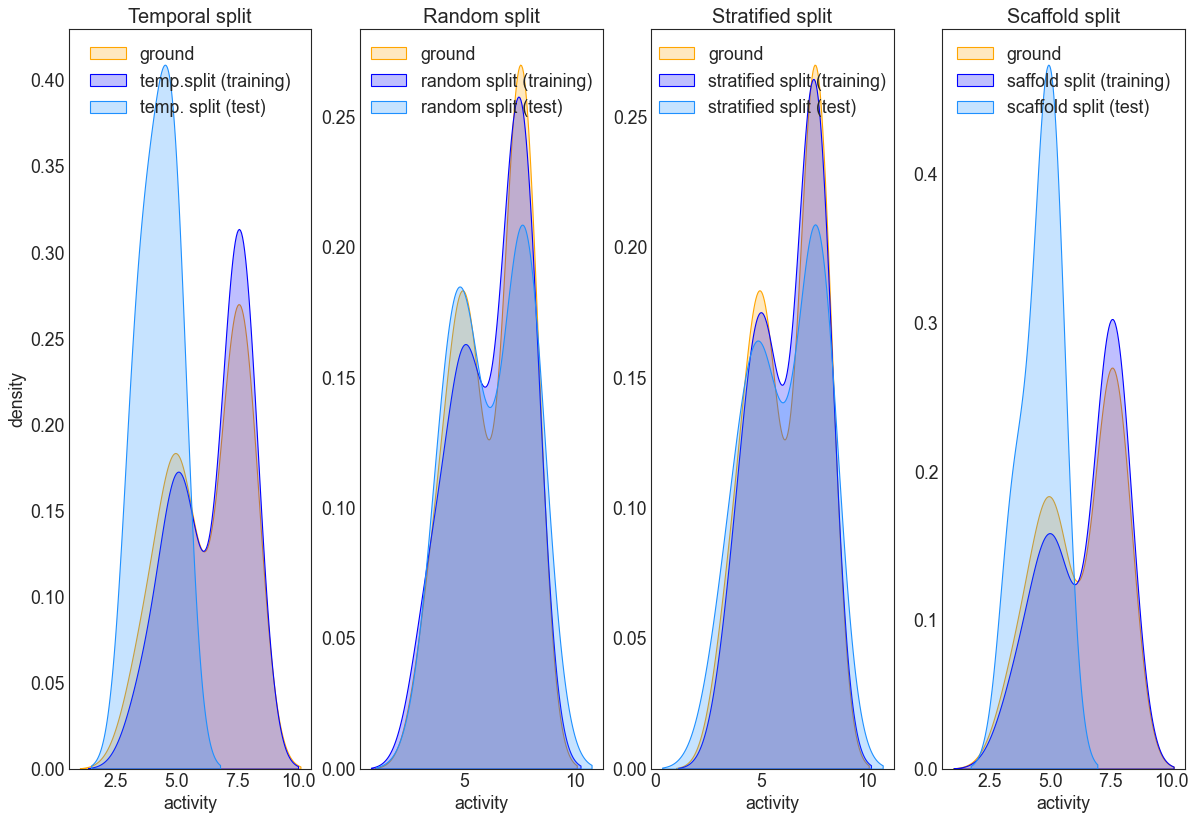

In [14]:
# make a density plot to compare the strategies
plt.figure(figsize=(18,12), dpi=80)

# left plot
plt.subplot(1, 4, 1)
plt.xlabel("activity")
plt.ylabel("density")
plt.title("Temporal split", fontsize=18)
sns.kdeplot(df_med_temporal["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med_temporal.loc[train_temporal]["activity"], shade=True, color="blue", label="temp.split (training)", alpha=0.25)
sns.kdeplot(df_med_temporal.loc[test_temporal]["activity"], shade=True, color="dodgerblue", label="temp. split (test)", alpha=0.25)
plt.legend(loc="upper center")

# middle left plot
plt.subplot(1, 4, 2)
plt.xlabel("activity")
plt.ylabel(" ")
plt.title("Random split", fontsize=18)
sns.kdeplot(df_med["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[train_ran]["activity"], shade=True, color="blue", label="random split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[test_ran]["activity"], shade=True, color="dodgerblue", label="random split (test)", alpha=0.25)
plt.legend(loc="upper center")

# middle right plot
plt.subplot(1,4,3)
plt.xlabel("activity")
plt.ylabel(" ")
plt.title("Stratified split", fontsize=18)
sns.kdeplot(df_med["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[train_str]["activity"], shade=True, color="blue", label="stratified split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[test_str]["activity"], shade=True, color="dodgerblue", label="stratified split (test)", alpha=0.25)
plt.legend(loc="upper center")

# right plot
plt.subplot(1,4,4)
plt.xlabel("activity")
plt.ylabel(" ")
plt.title("Scaffold split", fontsize=18)
sns.kdeplot(df_med["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[train_sca]["activity"], shade=True, color="blue", label="saffold split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[test_sca]["activity"], shade=True, color="dodgerblue", label="scaffold split (test)", alpha=0.25)
plt.legend(loc="upper center")

# do the legend and render
plt.show()

## Transform of data inputs  <a class="anchor" id="transformation"></a>
Qptuna can perform two types of transforms on input labels either a probabilistic transformation named Probabilistic Threshold Representation (PTR) or simple logarithmic scaling. The latter is a required step for data that is not normally distributed for most Machine Learning inputs. These approaches are discussed in more detail in the following sections.

## Log transform of user input data <a class="anchor" id="log"></a>

For some molecule proprety prediction tasks that are non-linear, activity endpoints are routinely log transformed to ensure the generation of predictive models. This is because a linear model applied to non-linear activity data will not be precise due to the non-linearity of the activity scale. A logarithmic function can be used to linearise the molecule property scale, affording better performance/prediction.


### Importance of log transformation <a class="anchor" id="transform-importance"></a>

Most algorithms assume numerical co-variates have a Gaussian (normally distributed) probability distribution. In reality, input data may or may not have a normal distribution. Some may have a Gaussian-like distribution (e.g. nearly Gaussian but with outliers or a skew) whilst other may exhibit totally different distribution (e.g. exponential scale). For this reason, superior performance for a wide range of machine learning algorithms is obtained by performing a transformation to user inputs and/or output variables to have a Gaussian or Gaussian-like distribution.

A good example of this is the conversion of principal (IC50) activity results to the pXC50 (negative log base), which have already been precomputed outside of Qptuna in the following example:

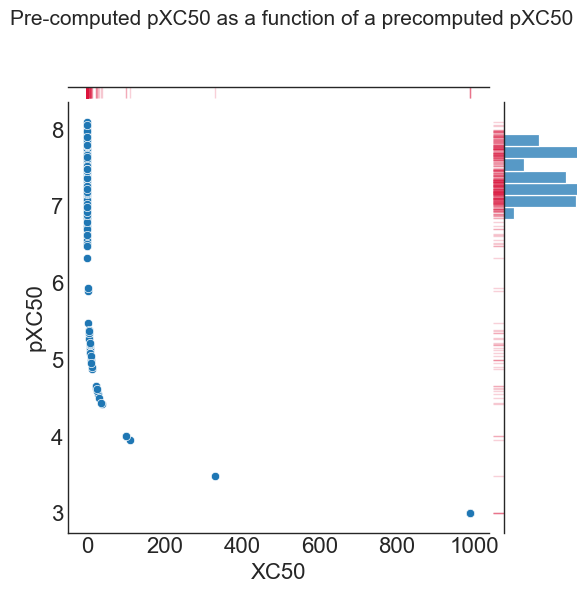

In [15]:
from optunaz.datareader import Dataset

#Load a dataset selecting the principal result (raw XC50 values)
xc50_data = Dataset(
    input_column="Smiles",
    response_column="Measurement",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepAllNoDeduplication(),
)

#Load a dataset selecting the pre-computed transformed result (pXC50 values)
pxc50_data = Dataset(
    input_column="Smiles",
    response_column="pXC50",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepAllNoDeduplication(),
)

comparison=pd.DataFrame(zip(xc50_data.get_sets()[1], pxc50_data.get_sets()[1]), columns=['XC50','pXC50'])
#plot raw vs. pXC50 log transform
g = sns.jointplot(data=comparison, x="XC50", y="pXC50")
g.fig.suptitle("Pre-computed pXC50 as a function of a precomputed pXC50", fontsize=15)
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

As illustrated in the above plot, the raw data (X axis & histogram at the top) shows a very skewed (heteroscedastic) distribution toward low values. In comparison, the negative log10^6 scaled pXC50 values (y-axis & histogram on the right) exhibits a more normal (homoscedastic) distribution of points. For this example, the log transformation yields a data set that should generate more predictive models.

### Qptuna logarithmic transformation <a class="anchor" id="transform-importance"></a>


Qptuna implements a 'ModelDataTransform' transormation method for converting numerical input or output variables to have a Gaussian or more-Gaussian-like distribution, which can be performed like so:

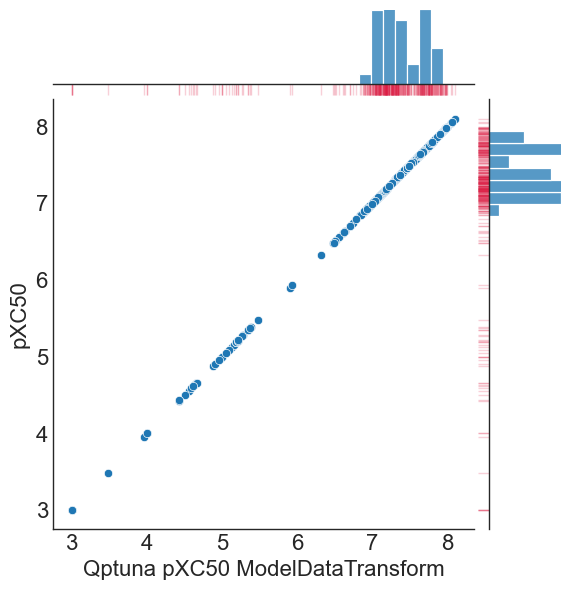

In [16]:
from optunaz.utils.preprocessing.transform import (
    LogBase,
    LogNegative,
    ModelDataTransform
)

transform = ModelDataTransform.new(
    base=LogBase.LOG10,
    negation=LogNegative.TRUE,
    conversion=6
)

comparison['Qptuna pXC50 ModelDataTransform'] = transform.transform(comparison['XC50'])

g = sns.jointplot(data=comparison, x="Qptuna pXC50 ModelDataTransform", y="pXC50")
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

### Performing data transform within the Datareader <a class="anchor" id="dataset-transform"></a>

There are different logartihmic functions (`log_transform_base`) to transform the activity scale, which are outlined below:
* `Log`: perform a standard log function (np.log)
* `Log2`: perform a log2 function (np.log2)
* `Log10`: perform a log10 function (np.log10) [default]

Users can also specify whether to negate the transformation (`log_transform_negative`) and also to perform a log transform unit conversion by a power of 10^X (`log_transform_unit_conversion`), where X is an integer to be specified by a user.

These options can be supplied to the Dataset datareader, and, as an example, a `log_transform_base` set to perform a Log10, `log_transform_negative`=LogNegative.TRUE, and a `log_transform_unit_conversion` of 6 is used to convert uM values to pXC50. This is demonstrated in the following:

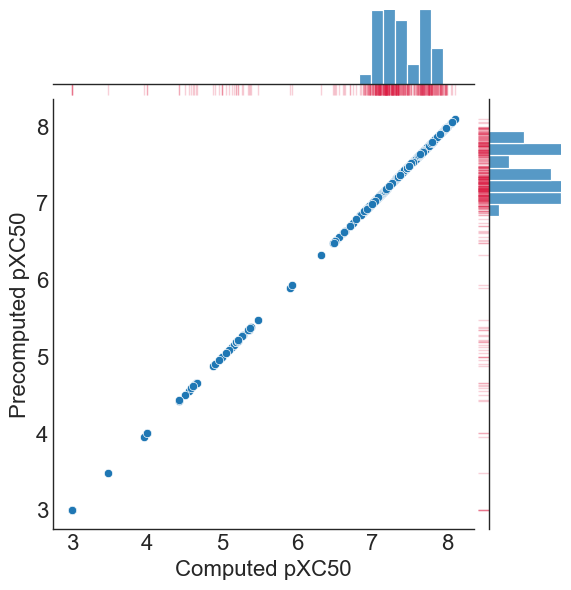

In [17]:
# Example of how to perform dataset transform within the Datareader
dataset_transformed = Dataset(
    input_column="Smiles",
    response_column="Measurement",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepAllNoDeduplication(),
    log_transform="True", # flags to use a transform
    log_transform_base=LogBase.LOG10, # Log10 base will be used
    log_transform_negative="True", # The negated log transform will be applied
    log_transform_unit_conversion=6 # THe unit conversion for pXC50 values is 6
)

pxc50_data = Dataset(
    input_column="Smiles",
    response_column="pXC50",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepAllNoDeduplication(),
)

comparison=pd.DataFrame(zip(dataset_transformed.get_sets()[1], pxc50_data.get_sets()[1]), columns=['Computed pXC50','Precomputed pXC50'])
#plot raw vs. pXC50 log transform
g = sns.jointplot(data=comparison, x="Computed pXC50", y="Precomputed pXC50")
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

As illustrated, a `log_transform_base` set to perform a Log10, `log_transform_negative`=LogNegative.TRUE, and a `log_transform_unit_conversion` of 6 reproduces the pXC50 conversion we had pre-computed in the file.

NB: the log transformation is reversed at inference. I.e. only the model is trained with the transformed values, any predictions will be output to the original scale as provided in user input data.

Qptuna also implements the reverse of the transform using `reverse_transform`, so that users can obtain values on the original scale at inference, like so:

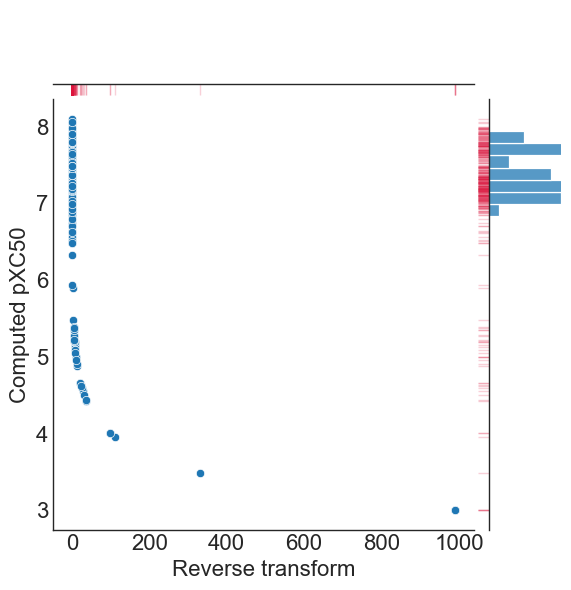

In [18]:
#plot raw vs. pXC50 log transform
comparison['Reverse transform']=transform.reverse_transform(comparison['Computed pXC50']) #reverse_transform applied
g = sns.jointplot(data=comparison, x="Reverse transform", y="Computed pXC50")
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

## Probabilistic Threshold Representation (PTR) and experimental error  <a class="anchor" id="ptr"></a>
PTR is a technique to model the uncertainty of experimental error (first reported by Mervin et al.[1]), which converts user response columns into a framework somewhere between regression and classification.

### Definition of the PTR <a class="anchor" id="ptr-def"></a>

Molecule properties derived from experiments have reproducibility limits due to experimental errors. Any model based on this data have such unavoidable error influencing performance which should ideally be factored into modelling and output predictions, such as the actual standard deviation of experimental (replicate) measurements (i.e. σ) or the associated comparability of activity values between aggregated heterogenous activity units (e.g., Ki versus IC50 values) during dataset assimilation (see [1] for a detailed analysis on this).

Since uncertainty originates from the hypothesis that experimental data has a degree of uncertainty, compound response labels can be treated as probability distribution functions (rather than deterministic values) on a per-threshold basis ($p_{ActivityT}$) given a standard deviation (σ) threshold. For each bioactivity value ($p_{Activity}$), the cumulative distribution function (cdf) of a normal distribution (Eq. 1) with a mean equal to the bioactivity threshold for each $p_{ActivityT}$ can be used:
$$
\Delta y\left( {\vec{c}} \right) = \frac{1}{2}\left[ {1 + {\text{erf}}\left( {\frac{{\overrightarrow {{p_{Activity} }} - \overrightarrow {{p_{Threshold} }} }}{\sigma \sqrt 2 }} \right)} \right]
$$

Eq.1

More concretely, assuming only the mean and variance of response column values is known, the maximum entropy distribution to represent these values is a normal distribution. One can set the mean and variance parameters of this distribution to a response columns threshold value (e.g., pXC50 of 5), and experimental error (e.g., σ of 0.3) and compute the probability of activity values with the cdf. A sensible arbitrary default can be provided when experimental error is unknown. Each $p_{Activity}$ value is therefore converted to a y-label probability (∆y), a value representing the uncertainty in the measurement, which can be used for training (using either a probabilistic random forest (PRF) or regression algorithm). A schematic representation/lookup table of how the PTR works is shown below.

![title](../docs/images/ptr.png)

Response column values (e.g. pXC50) are converted into the ideal y-label probability using cdf with different bioactivity thresholds and standard deviation (SD) values. E.g. a response column of 5.1, would be assigned a PTR of 0.63 given a cutoff of 5.0 and σ (SD) of 0.3. The case when SD is 0 corresponds to the traditional classification at a cutoff scenario.

PTR hence represents the activity in a framework in-between the classification and regression architecture, with philosophical differences from either approach. Compared to classification, this approach enables better representation of factors increasing/decreasing inactivity. Conversely, one can utilize all data (even delimited/operand/censored data far from a cut-off) at the same time as taking into account the granularity around the cut-off, compared to a conventional regression framework. Thereby, PTR combines characteristics from both classification and regression settings.

NB: Qptuna treats the PTR values as the ‘ideal y-label’, i.e. they become the new response column values for train/test/validation performance evaluation, since it represents the ideal case, where experimental error is taken into account and model outputs most closely reflect this.


[1] https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00539-7#Sec12

### Qptuna implementation of the PTR

PTR is also easily applied within the Datareader class by specifying the PTR options to the Qptuna datareader. E.g:

In [19]:
pxc50_threshold=5
pxc50_std=0.3

# ptr query for the exmaple sdf
ptr_data = Dataset(
    input_column="Smiles",
    response_column="pXC50",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepMedian(),
    split_strategy=Random(fraction=0.2, seed=42),
    probabilistic_threshold_representation=True, # This enables PTR
    probabilistic_threshold_representation_threshold=pxc50_threshold, # This defines the activity threshold
    probabilistic_threshold_representation_std=pxc50_std, # This captures the deviation/uncertainty in the dataset
)

# normal query (ptr not applied) for the exmaple sdf
data = Dataset(
    input_column="Smiles",
    response_column="pXC50",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepMedian(),
    split_strategy=Random(fraction=0.2, seed=42),
)

#gather response col values before & after applying the ptr
datareaders = pd.DataFrame(zip(ptr_data.get_sets()[1], data.get_sets()[1]))

#get pXC50 value at the limit of ~100% inactive certainty 
lower_reproducability=datareaders[datareaders.astype(float).round(3)[0]==0][1].max()

#get pXC50 value at the limit of ~100% active certainty 
upper_reproducability=datareaders[datareaders.astype(float).round(3)[0]==1][1].min()

The distribution for the PTR dataloader looks like this (note the a somewhat inverted bell shape):

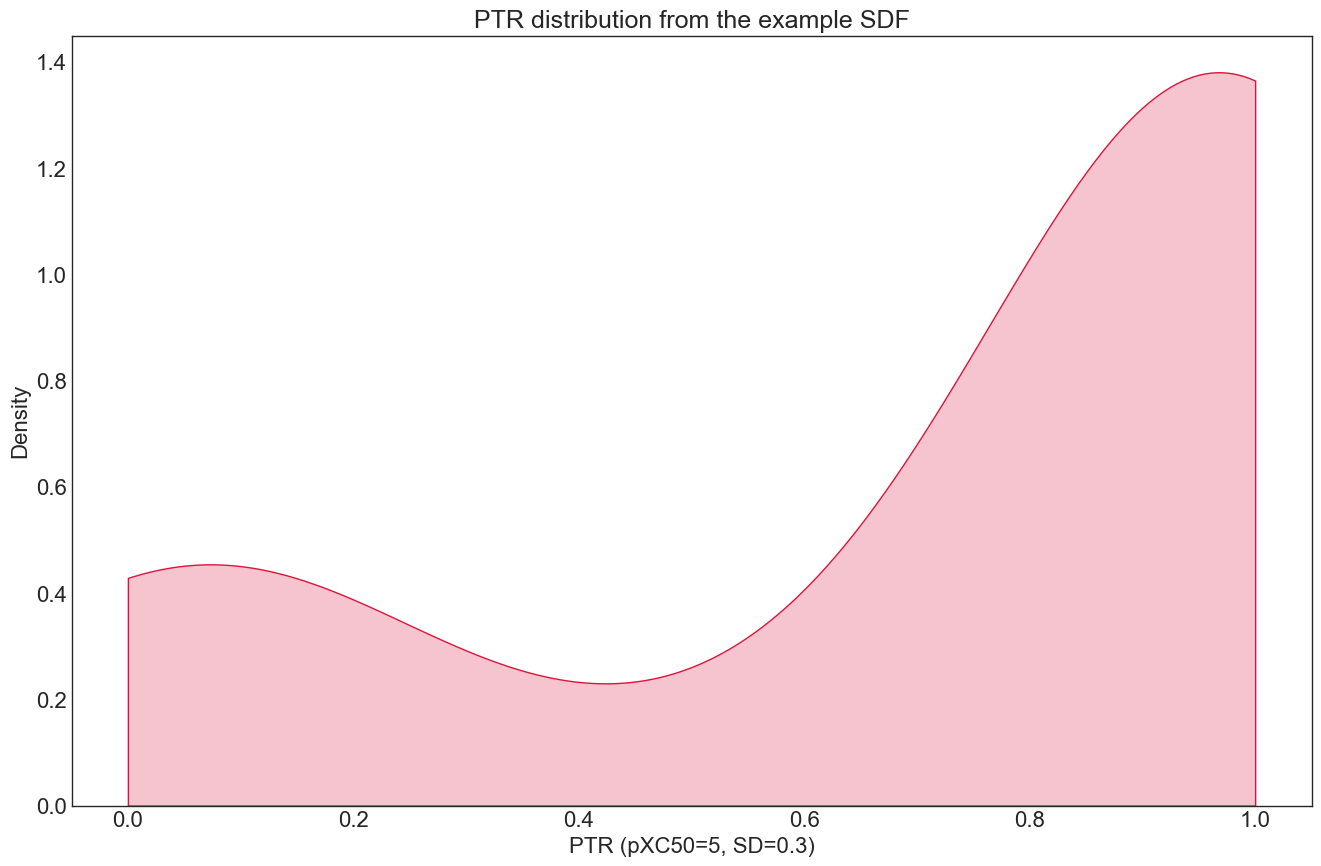

In [20]:
#plot the kde for the ptr
plt.title("PTR distribution from the example SDF", fontsize=18)
plt.xlabel(f"PTR (pXC50={pxc50_threshold}, SD={pxc50_std})")
plt.ylabel("Density")
sns.kdeplot(data=datareaders[0], shade=True, \
            color="crimson", label="ptr ground", \
            alpha=0.25, cut=0)
plt.show()

Plotting the PTR as a function of the pXC50 outlines how the PTR transform behaves for our data:

/var/folders/1v/9y_z128d7gvcp8mf8q0pz3ch0000gq/T/ipykernel_82497/1725493911.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color(uncert_color)
/var/folders/1v/9y_z128d7gvcp8mf8q0pz3ch0000gq/T/ipykernel_82497/1725493911.py:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_alpha(.2)


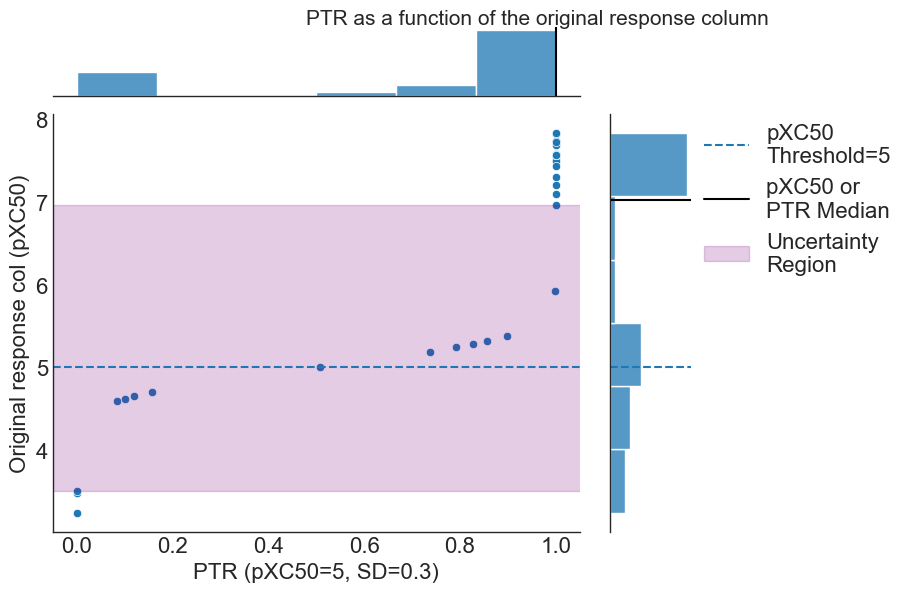

In [21]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

#relate the ptr versus the no ptr query
g = sns.jointplot(data=datareaders,x=0,y=1)
g.fig.suptitle("PTR as a function of the original response column", fontsize=15)
g.ax_joint.set_xlabel(f"PTR (pXC50={pxc50_threshold}, SD={pxc50_std})")
g.ax_joint.set_ylabel("Original response col (pXC50)")
g.ax_joint.axhline(y=pxc50_threshold,linestyle='--') #add threshold line to main plot
plt.axhline(y=pxc50_threshold,linestyle='--') #add threshold line to y margin

#add median to margin histograms
g.ax_marg_x.axvline(x=datareaders[0].median(),color='k')
g.ax_marg_y.axhline(y=datareaders[1].median(),color='k')

#plot the region of uncertainty given the pxc50_threshold and pxc50_std
uncert_color="purple"
uncert_region=mpatches.Rectangle((-1,lower_reproducability),3,
                        upper_reproducability-lower_reproducability, 
                        fill = True, alpha = .2,
                        color = uncert_color)
g.fig.axes[0].add_patch(uncert_region)

# create the legend & make include uncertainty box 
plt.legend(title='', \
           labels=[f'pXC50\nThreshold={pxc50_threshold}', \
                   'pXC50 or\nPTR Median','Uncertainty\nRegion'], \
           fancybox=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg = g.fig.axes[2].get_legend()
leg.legendHandles[2].set_color(uncert_color)
leg.legendHandles[2].set_alpha(.2)


#show the plot in tight layout
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.fig.set_size_inches((12, 6))

plt.show()

where the PTR threshold [`pXC50 = 5`] is outlined via the dashed blue line, region of uncertainty for class membership given the standard deviation of experimental error shown via purple shading, and PTR and pXC50 scale medians shown via black lines within the margin histrograms, respectively.

We observe the clipping toward perfectly certain (~100%) compounds belonging to active or inactive classes at either end of the activity scale (outside the purple shaded region), leading to the aforementioned inverted bell shape distribution.

The PTR can also be applied using the 'PTRTransform' class directly:

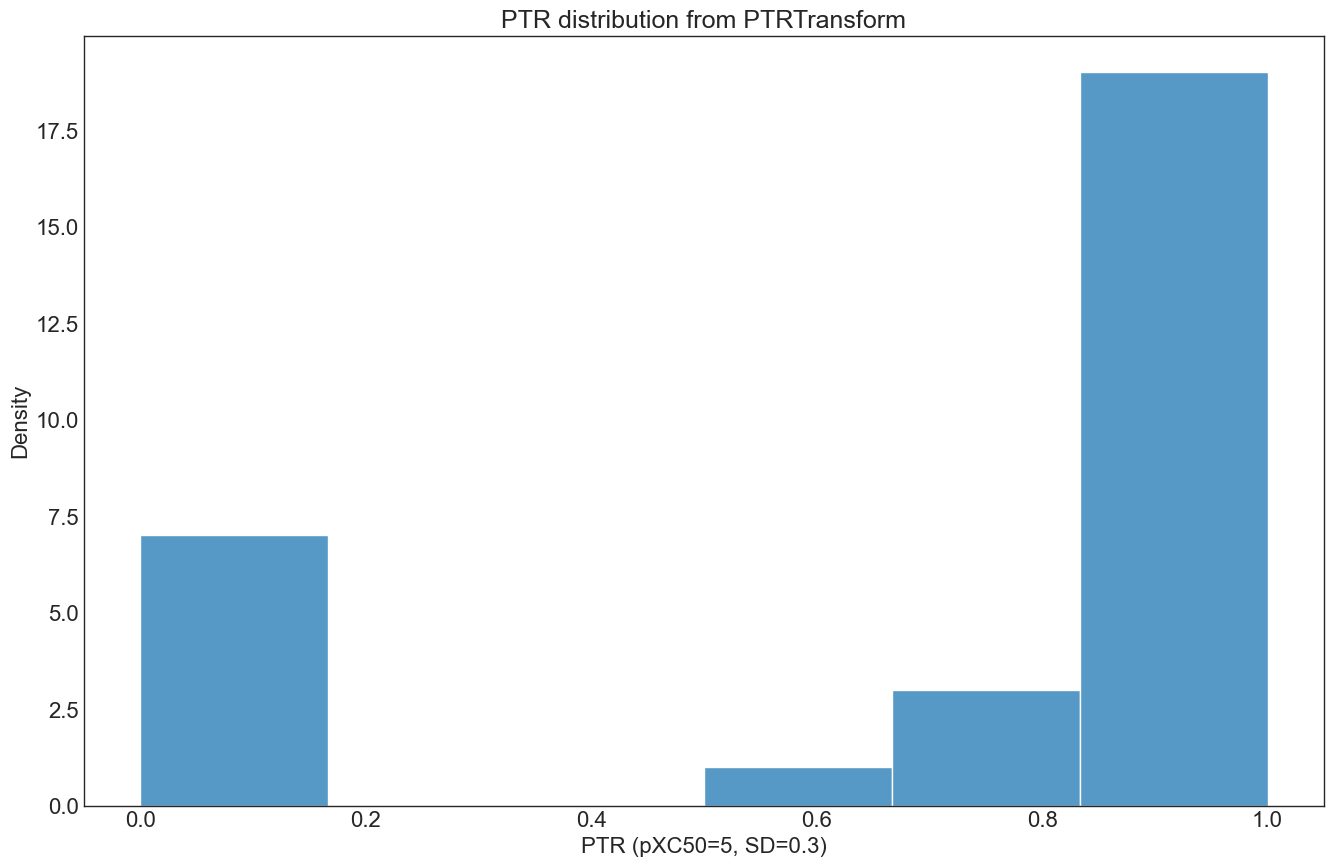

In [22]:
from optunaz.utils.preprocessing.transform import PTRTransform

# normal query (ptr not applied) for the exmaple sdf
data = Dataset(
    input_column="Smiles",
    response_column="pXC50",
    response_type="regression",
    training_dataset_file="../tests/data/sdf/example.sdf",
    deduplication_strategy=KeepMedian(),
    split_strategy=Random(fraction=0.2, seed=42),
)

ptr_transformed = PTRTransform.new(threshold=5, std=0.3)
datareader = pd.DataFrame(data.get_sets()[1])

plt.title("PTR distribution from PTRTransform", fontsize=18)
plt.xlabel(f"PTR (pXC50={pxc50_threshold}, SD={pxc50_std})")
plt.ylabel("Density")
sns.histplot(ptr_transformed.transform(datareader['response']))
plt.show()

### Conclusion:  PTR calculation, evaluation of experimental reproducability & best practices   <a class="anchor" id="best-practices-ptr"></a>

In this section, we next also look at how the PTR within the Qptuna datareader is implemented, and show how a user can assess the experimental reproducability/uncertainty for their query dataset.

First we start with imports and define the PTR function using `stats.norm.cdf` from scipy

In [23]:
import scipy
from scipy import stats

# calculate the ptr for a resp_col value based on sd & threshold
def ptr(resp_col, threshold, sd):
    return scipy.stats.norm.cdf(resp_col, threshold, sd).round(3)

#r2 for activity dependent error analysis plot
def r2(x, y):
    return np.round(stats.pearsonr(x, y)[0] ** 2,2)

Now we can group property measurement replicates via their structure (SMILES), and calculate the standard deviation for those replicates, also noting the median value across the replicates for each compound (in the same way as the aforementioned `KeepMedian()` deduplication method)

In [24]:
#standard deviation across compound replicates 
std_df = primarydf.groupby("smiles").std()
#median across compound replicates 
mdn_df = primarydf.groupby("smiles").median()
#create dataframe between standard deviation and the median across replicates 
std_vs_median=std_df.merge(mdn_df,on="smiles", suffixes=["_std", "_median"]).dropna()
#show example of replicate data
std_vs_median=std_vs_median.reset_index(drop=True)
std_vs_median.index.name='Compound Index'
std_vs_median.head()

,activity_std,activity_median
Compound Index,,
0,0.088539,7.684240
1,0.674782,3.481464
2,0.265123,7.732625
3,0.138620,7.568332
4,0.157605,7.790259


The mean overall standard deviation of experimental error across replicates can be hence derived:

In [25]:
stdev=std_vs_median["activity_std"].mean().round(2)
print(f'Standard deviation of experimental results:{stdev}')

Standard deviation of experimental results:0.22


As a best practice, we can now analyse if experimental error has an activity dependent correlation for our query dataset:

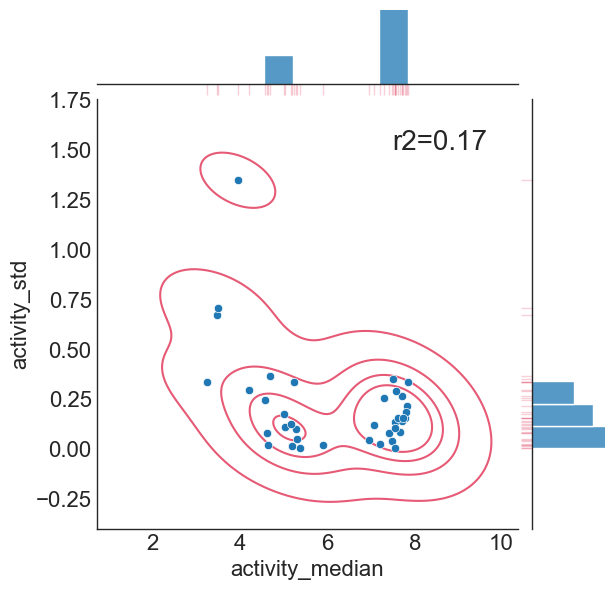

In [26]:
#r2 of median vs. std
stat_func = r2(std_vs_median["activity_median"],std_vs_median["activity_std"])

#plot median vs. std dev
g = sns.jointplot(data=std_vs_median, x="activity_median", y="activity_std")
g.ax_joint.text(x=7.5,y=1.5,s=f"r2={stat_func}",fontsize=20)
g.plot_joint(sns.kdeplot, color="crimson", zorder=0, levels=5,alpha=.7)
g.plot_marginals(sns.rugplot, color="crimson", height=-.15, clip_on=False, alpha=.2)

Hence, we conclude there is no significant correlation between deduplicated experimental value and the standard deviation of those replicates (hence experimental uncertainty is homoscedastic), and the assumptions made by PTR transform are fulfilled according to the analysis presented here.

Next we can outline how a PTR fold would look for the different splits, given our experimental deviation, and for a threshold of `PXC50=6`. First we can calculate the split as so:

In [27]:
# create the ptr column, generate train and test sets given the ptr, respectively
pxc50_threshold = 6 #defined pxc50 threshold
df_med["ptr"] = ptr(df_med["activity"],pxc50_threshold,stdev) #add the ptr column to the dataframe
ptr_train_ran, ptr_test_ran = Random(fraction=0.3, seed=42).split(df_med["smiles"]) #random split
ptr_train_str, ptr_test_str = Stratified(fraction=0.4, seed=42).split(df_med["smiles"], df_med["ptr"]) #stratified split
ptr_train_temporal, ptr_test_temporal = Temporal(fraction=0.1).split(df_med["smiles"]) #temporal split
#scaffold split
scaf_split = ScaffoldSplit()
scaffolds = scaf_split.groups(df_med, "smiles")
groups = df_med["smiles"].map(scaffolds)
ptr_train_sca, ptr_test_sca = scaf_split.split(df_med["smiles"], df_med["ptr"], groups=groups)

The PTR behaves differently to the distribution of input values, so it would be interesting to contrast ground distribution for the activity and the train-test distributions obtained from splitting strategies as above:

/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qptuna-_QsKTRFT-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/kljk345/Library/Caches/pypoetry/virtualenvs/qptuna-_QsKTRFT-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


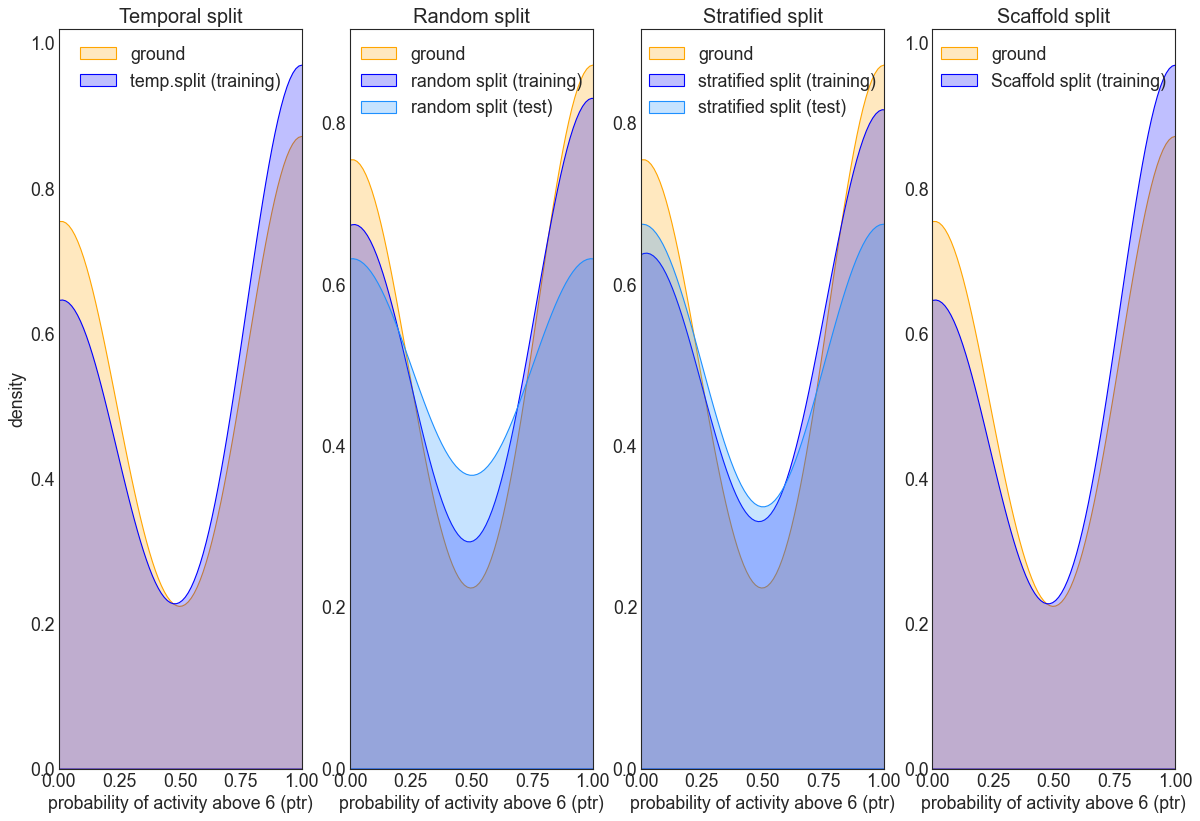

In [28]:
# make a density plot to compare the strategies
plt.figure(figsize=(18,12), dpi=80)

# left plot
plt.subplot(1, 4, 1)
plt.xlabel(f"probability of activity above {pxc50_threshold} (ptr)")
plt.ylabel("density")
plt.title("Temporal split", fontsize=18)
sns.kdeplot(df_med["ptr"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_train_temporal]["ptr"], shade=True, color="blue", label="temp.split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_test_temporal]["ptr"], shade=True, color="dodgerblue", label="temp. split (test)", alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,1)

# middle left plot
plt.subplot(1, 4, 2)
plt.xlabel(f"probability of activity above {pxc50_threshold} (ptr)")
plt.ylabel(" ")
plt.title("Random split", fontsize=18)
sns.kdeplot(df_med["ptr"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_train_ran]["ptr"], shade=True, color="blue", label="random split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_test_ran]["ptr"], shade=True, color="dodgerblue", label="random split (test)", alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,1)

# middle right plot
plt.subplot(1,4,3)
plt.xlabel(f"probability of activity above {pxc50_threshold} (ptr)")
plt.ylabel(" ")
plt.title("Stratified split", fontsize=18)
sns.kdeplot(df_med["ptr"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_train_str]["ptr"], shade=True, color="blue", label="stratified split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_test_str]["ptr"], shade=True, color="dodgerblue", label="stratified split (test)", alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,1)

# right plot
plt.subplot(1,4,4)
plt.xlabel(f"probability of activity above {pxc50_threshold} (ptr)")
plt.ylabel(" ")
plt.title("Scaffold split", fontsize=18)
sns.kdeplot(df_med["ptr"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_train_sca]["ptr"], shade=True, color="blue", label="Scaffold split (training)", alpha=0.25)
sns.kdeplot(df_med.loc[ptr_test_sca]["ptr"], shade=True, color="dodgerblue", label="Scaffold split (test)", alpha=0.25)
plt.legend(loc="upper center")
plt.xlim(0,1)

# do the legend and render
plt.show()

This above provides an example of the typical splitting distribution when using PTR across the different strategies. 

It can be seen via the inverted bell shape curve that the distributions peak to either extemes on the PTR scale. The figures also show cases when data distributions are different between training and test, when the resulting model will likely not generalize well to the test set. 

As before, the random split roughly resembles the ground distribution, whilst the stratified does an even better job in this respect. 

N.B: In comparison to the earlier splitting density analysis, similar dsitributions to the above are expected for even larger datasets, since the PTR preprocessing step will always "clip" values that are far away from the threshold or decision boundary, which hence biases y-labels toward either ends of the scale.